In [1]:
from keras_preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\LENOVO\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\LENOVO\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\LENOVO\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
img_size=256
b_size=32
channels=3
EPOCHS=50

In [3]:
#It will load the images from a directory as tensors
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "Potato-Data",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=b_size
)

Found 2152 files belonging to 3 classes.


In [4]:
#How many classes are there in the image dataset
classes=dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#1 batch is of 30 so 30*72=2160 (pictures or elements)
len(dataset)

68

(32, 256, 256, 3)
tf.Tensor([1 1 1 1 0 1 1 2 0 0 0 0 1 1 0 2 0 0 1 0 1 1 0 0 1 1 1 0 0 2 1 1], shape=(32,), dtype=int32)
[1 1 1 1 0 1 1 2 0 0 0 0 1 1 0 2 0 0 1 0 1 1 0 0 1 1 1 0 0 2 1 1]



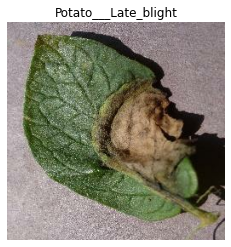

In [6]:
for image_batch, label_batch in dataset.take(1):
    #if u want to take 5 datasets the dataset.take(5)
    #if you want to skip 5 dataset then dataset.skip(5)
    print(image_batch.shape)
    print(label_batch)
    print(label_batch.numpy())
    #print(image_batch[0].numpy())
    print()
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(classes[label_batch[0]])
    
#we have 30 images each img of 256x256 and 3 RGB channels

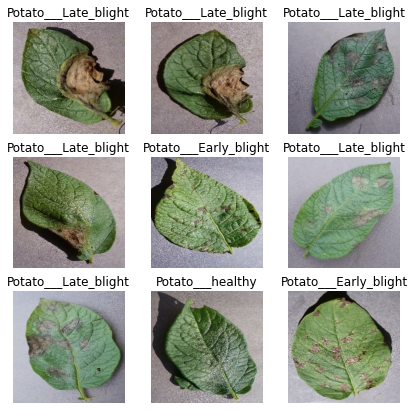

In [7]:
#Now lets print some more images
plt.figure(figsize=(7,7))
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(classes[label_batch[i]])

In [8]:
def data_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(ds_size*train_split)
    val_size= int(val_split*ds_size)
    
    train_ds= ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds= data_split(dataset)

In [10]:
len(train_ds)
#len(val_ds)
#len(test_ds)

54

Prefetching overlaps the preprocessing and model execution of a training step.
While the model is executing training step s, the input pipeline is reading the data for step s+1.
You could either manually tune this value, or set it to tf.data.AUTOTUNE, 
which will prompt the tf.data runtime to tune the value dynamically at runtime.
cache() keeps the images in memory after they have been loaded off disk during the first epoch.
This will ensure that the dataset doesn't become a bottleneck when the model is being trained.

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
from tensorflow.keras import models, layers

In [13]:
#This model is created to take care of image size and scale during prediction of
#any random image which is of different shape and scale

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),
                                         ])

In [14]:
#This model is created to to create images into diffent angles using flip and rotation.
#Basically from 1 image we will get multiple samples to train

data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

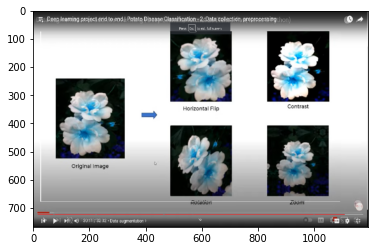

In [15]:
#Displaying an image of augmentation concept
import matplotlib.image as mpimg
aug = mpimg.imread("img_augmentation.png")
plt.imshow(aug)

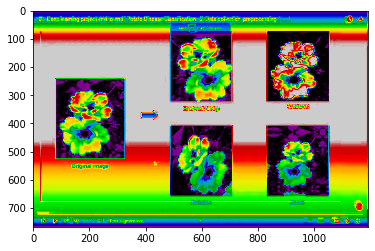

In [16]:
#We currently have an RGB image. Since R, G, and B are all similar (see for yourself above or in your data),
#we can just pick one channel of our data
lum_img = aug[:, :,0]

#Now, with a luminosity (2D, no color) image, the default colormap (aka lookup table, LUT), is applied.
#The default is called viridis. There are plenty of others to choose from.

plt.imshow(lum_img,cmap="nipy_spectral")

In [17]:
#Now we create a CNN model including the above two models
input_shape = (b_size, img_size, img_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

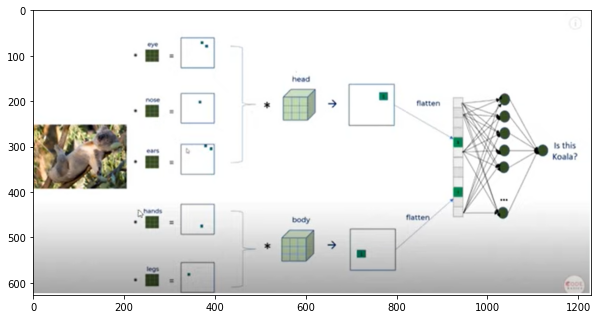

In [18]:
#Different filters are applied for an omage in CNN model
#eyes,nose,ears ets are filters applied
plt.figure(figsize=(10,10))
filters = mpimg.imread("filters.png")
plt.imshow(filters)

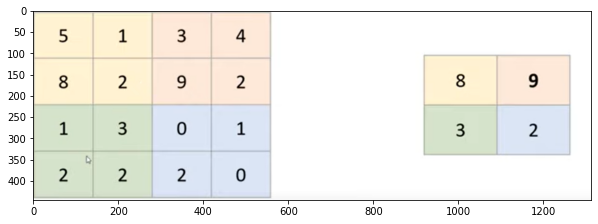

In [19]:
plt.figure(figsize=(10,10))
poling = mpimg.imread("polling.png")
plt.imshow(poling)

# CNN steps
1.apply filters
2.Pooling
3.Flatten


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [21]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=b_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 118s 2s/step - loss: 0.9083 - accuracy: 0.4977 - val_loss: 0.8795 - val_accuracy: 0.7448
Epoch 2/50
54/54 [==============================] - 104s 2s/step - loss: 0.7631 - accuracy: 0.6464 - val_loss: 0.5910 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 107s 2s/step - loss: 0.5963 - accuracy: 0.7350 - val_loss: 0.4786 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 121s 2s/step - loss: 0.4092 - accuracy: 0.8368 - val_loss: 0.3192 - val_accuracy: 0.8594
Epoch 5/50
54/54 [==============================] - 112s 2s/step - loss: 0.3609 - accuracy: 0.8611 - val_loss: 0.2575 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 117s 2s/step - loss: 0.3176 - accuracy: 0.8773 - val_loss: 0.3311 - val_accuracy: 0.8698
Epoch 7/50
54/54 [==============================] - 116s 2s/step - loss: 0.2596 - accuracy: 0.9010 - val_loss: 0.2217 - val_accuracy: 0.9167
Epoch 8/50
54

In [23]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 326ms/step - loss: 0.0265 - accuracy: 0.9844


In [24]:
scores

[0.026540447026491165, 0.984375]

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

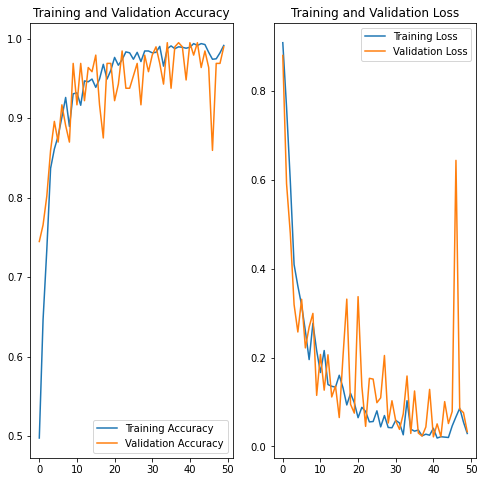

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


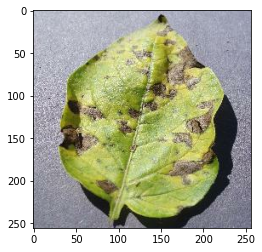

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

# Write a function for inference

In [29]:
def predict(model, img):
    #img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img, 0) 
    #You can add an outer batch axis by passing axis=0:
    #(1, 256, 256, 3) 1 is added bcoz of axis 0
        
    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 3)
    return predicted_class, confidence

# Now run inference on few sample images



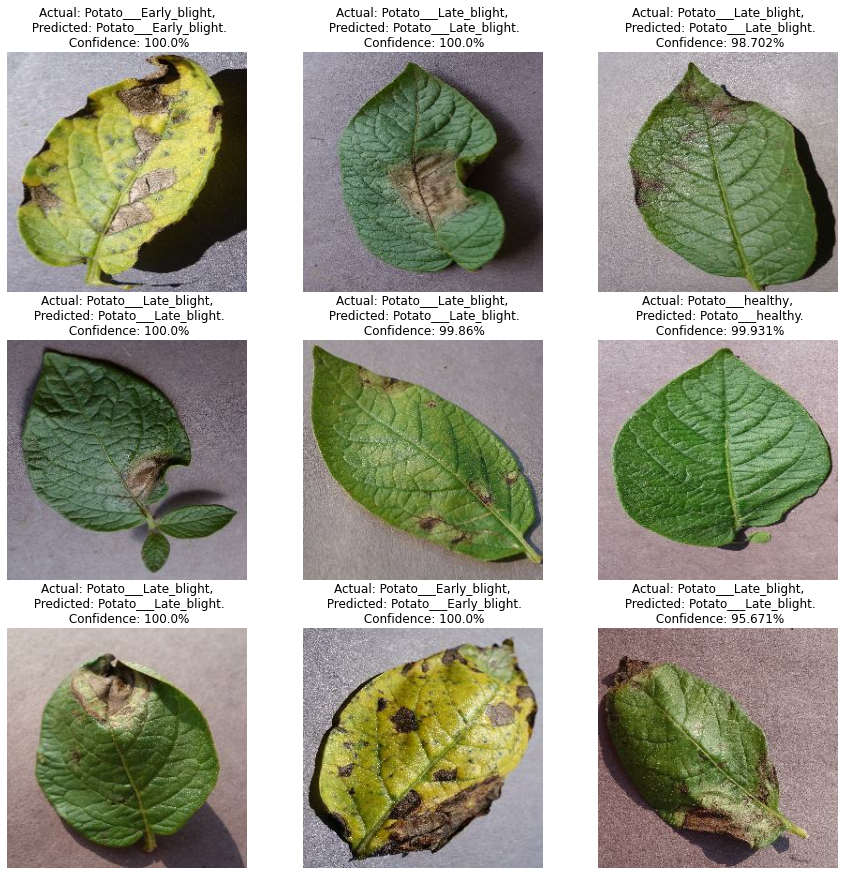

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [31]:
'''#simple experiment for the above function
for im, la in dataset.take(1):
    #print(im[0].numpy())
    a=im[0]
    print(a)
    print("---------------------------")
    c=tf.expand_dims(a, 0)
    print(c)
    #plt.imshow(image_batch[0].numpy().astype("uint8"))
    #plt.axis("off")
    #plt.title(classes[label_batch[0]])'''

'#simple experiment for the above function\nfor im, la in dataset.take(1):\n    #print(im[0].numpy())\n    a=im[0]\n    print(a)\n    print("---------------------------")\n    c=tf.expand_dims(a, 0)\n    print(c)\n    #plt.imshow(image_batch[0].numpy().astype("uint8"))\n    #plt.axis("off")\n    #plt.title(classes[label_batch[0]])'

# Saving the model

In [32]:
import os
model_version=max([int(i) for i in os.listdir("../DL_models") + [0]])+1
#auto-increment by 1
model.save(f"../DL_models/{model_version}")

INFO:tensorflow:Assets written to: ../DL_models/2\assets
